In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Generate mock sales data (copy your code here)
np.random.seed(42)
start_date = datetime(2020, 1, 1)
num_months = 48
date_rng = pd.date_range(start_date, periods=num_months, freq='MS')

sales_data = pd.DataFrame(date_rng, columns=['Date'])
base_sales = 10000 + np.arange(num_months) * 50
seasonal_component = 2000 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 12 + np.pi/2) + \
                     1500 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 6)
noise = np.random.normal(0, 500, num_months)

sales_data['SalesAmount'] = (base_sales + seasonal_component + noise).astype(int)
sales_data['SalesAmount'] = sales_data['SalesAmount'].clip(lower=2000)

sales_data['Promotion'] = np.random.choice([0, 1], num_months, p=[0.8, 0.2])
sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] = \
    (sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] * np.random.uniform(1.1, 1.3)).astype(int)

sales_data['HolidayMonth'] = (sales_data['Date'].dt.month == 12).astype(int)
sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] = \
    (sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] * np.random.uniform(1.15, 1.4)).astype(int)

print("Sample of the generated sales data:")
print(sales_data.head())


Sample of the generated sales data:
        Date  SalesAmount  Promotion  HolidayMonth
0 2020-01-01        12248          0             0
1 2020-02-01        13011          0             0
2 2020-03-01        12722          0             0
3 2020-04-01        14030          1             0
4 2020-05-01         7783          0             0


In [ ]:
# Make sure Date column is datetime type (should be already), then set as index
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data.set_index('Date', inplace=True)

print("\nData with Date as index:")
print(sales_data.head())



Data with Date as index:
            SalesAmount  Promotion  HolidayMonth
Date                                            
2020-01-01        12248          0             0
2020-02-01        13011          0             0
2020-03-01        12722          0             0
2020-04-01        14030          1             0
2020-05-01         7783          0             0


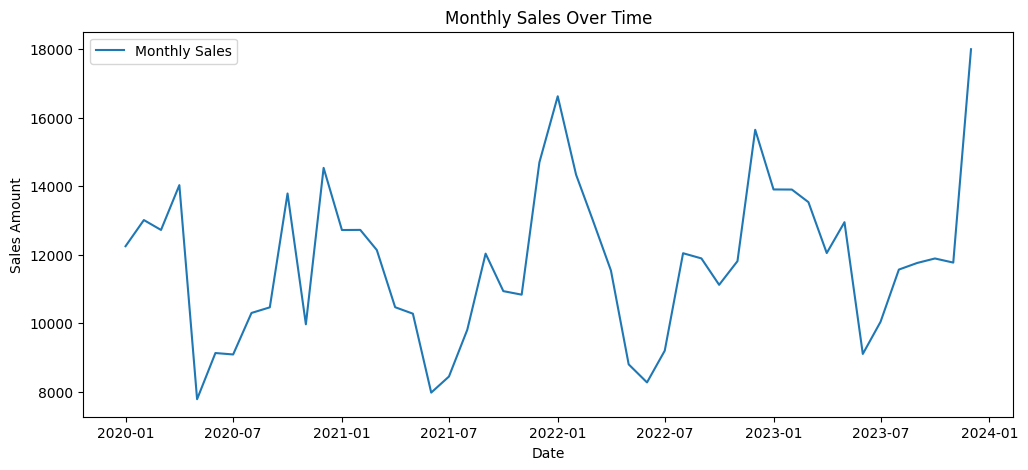

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(sales_data['SalesAmount'], label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_data['SalesAmount'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is NOT stationary. Differencing may be needed.")


ADF Statistic: -4.5142
p-value: 0.0002
The time series is stationary.


In [ ]:
print(f"Missing values per column:\n{sales_data.isnull().sum()}")

# If missing values exist, you can fill or drop them. For example:
# sales_data.fillna(method='ffill', inplace=True)
# Or
# sales_data.dropna(inplace=True)


Missing values per column:
SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64


In [ ]:
# Create lag features for last 1, 2, and 3 months
sales_data['Sales_Lag_1'] = sales_data['SalesAmount'].shift(1)
sales_data['Sales_Lag_2'] = sales_data['SalesAmount'].shift(2)
sales_data['Sales_Lag_3'] = sales_data['SalesAmount'].shift(3)

# Display the data to see lag columns
print(sales_data[['SalesAmount', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3']].head(6))


            SalesAmount  Sales_Lag_1  Sales_Lag_2  Sales_Lag_3
Date                                                          
2020-01-01        12248          NaN          NaN          NaN
2020-02-01        13011      12248.0          NaN          NaN
2020-03-01        12722      13011.0      12248.0          NaN
2020-04-01        14030      12722.0      13011.0      12248.0
2020-05-01         7783      14030.0      12722.0      13011.0
2020-06-01         9131       7783.0      14030.0      12722.0


In [ ]:
sales_data['Month'] = sales_data.index.month
sales_data['Quarter'] = sales_data.index.quarter

print(sales_data[['SalesAmount', 'Month', 'Quarter']].head())


            SalesAmount  Month  Quarter
Date                                   
2020-01-01        12248      1        1
2020-02-01        13011      2        1
2020-03-01        12722      3        1
2020-04-01        14030      4        2
2020-05-01         7783      5        2


In [ ]:
sales_data.dropna(inplace=True)


In [ ]:
# Number of months for training
train_size = 42

train = sales_data.iloc[:train_size]
valid = sales_data.iloc[train_size:]

print("Training data range:", train.index.min(), "to", train.index.max())
print("Validation data range:", valid.index.min(), "to", valid.index.max())


Training data range: 2020-04-01 00:00:00 to 2023-09-01 00:00:00
Validation data range: 2023-10-01 00:00:00 to 2023-12-01 00:00:00


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Train model on training data's SalesAmount
model = ExponentialSmoothing(train['SalesAmount'],
                             trend='add',      # Additive trend
                             seasonal='add',   # Additive seasonality
                             seasonal_periods=12)  # 12 months in a year (seasonality)

model_fit = model.fit()

# Forecast on validation period (6 months)
forecast = model_fit.forecast(len(valid))

# Compare forecast with actual validation sales
print(forecast)


2023-10-01    13306.716329
2023-11-01    11710.468889
2023-12-01    15925.337074
Freq: MS, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(valid['SalesAmount'], forecast)
rmse = np.sqrt(mean_squared_error(valid['SalesAmount'], forecast))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 1182.30
RMSE: 1448.94


In [ ]:
import statsmodels.api as sm

# SARIMA example (p,d,q) = (1,1,1), seasonal (P,D,Q,s) = (1,1,1,12)
sarima_model = sm.tsa.statespace.SARIMAX(train['SalesAmount'],
                                         order=(1,1,1),
                                         seasonal_order=(1,1,1,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

sarima_fit = sarima_model.fit()

sarima_forecast = sarima_fit.get_forecast(len(valid))
forecast_values = sarima_forecast.predicted_mean

# Evaluate
mae_sarima = mean_absolute_error(valid['SalesAmount'], forecast_values)
rmse_sarima = np.sqrt(mean_squared_error(valid['SalesAmount'], forecast_values))

print(f'SARIMA MAE: {mae_sarima:.2f}')
print(f'SARIMA RMSE: {rmse_sarima:.2f}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA MAE: 1211.46
SARIMA RMSE: 1398.71


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(valid['SalesAmount'], forecast_values)
mse = mean_squared_error(valid['SalesAmount'], forecast_values)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(valid['SalesAmount'], forecast_values)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


MAE: 1211.46
MSE: 1956403.07
RMSE: 1398.71
MAPE: 8.19%


In [ ]:
# If Date is already the index
full_data = sales_data.asfreq('MS')

# Then retrain SARIMA
final_model = sm.tsa.statespace.SARIMAX(full_data['SalesAmount'],
                                        order=(1,1,1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
final_fit = final_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
# Forecast next 6 months
forecast_steps = 6
forecast_result = final_fit.get_forecast(steps=forecast_steps)

# Extract predicted mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Print forecast with confidence intervals
print("Next 6 months forecast:")
print(forecast_mean)

print("\nConfidence Intervals:")
print(conf_int)


Next 6 months forecast:
2024-01-01    15536.550199
2024-02-01    14921.924900
2024-03-01    13989.810729
2024-04-01    12986.751332
2024-05-01    11917.674438
2024-06-01     9853.434667
Freq: MS, Name: predicted_mean, dtype: float64

Confidence Intervals:
            lower SalesAmount  upper SalesAmount
2024-01-01       13379.272223       17693.828174
2024-02-01       12760.100857       17083.748942
2024-03-01       11824.638310       16154.983149
2024-04-01       10820.039549       15153.463115
2024-05-01        9751.596147       14083.752729
2024-06-01        7687.472920       12019.396415


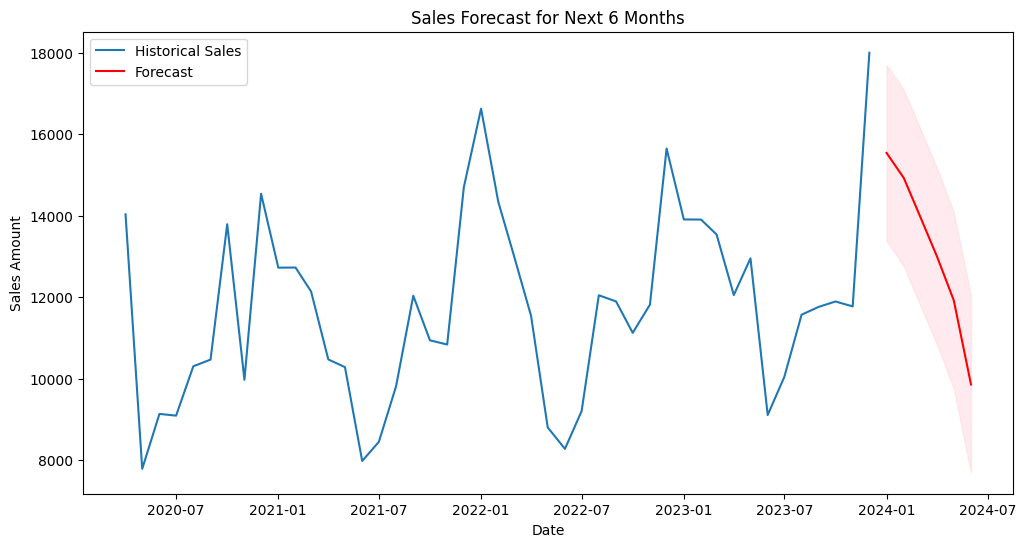

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(full_data.index, full_data['SalesAmount'], label='Historical Sales')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Sales Forecast for Next 6 Months')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()


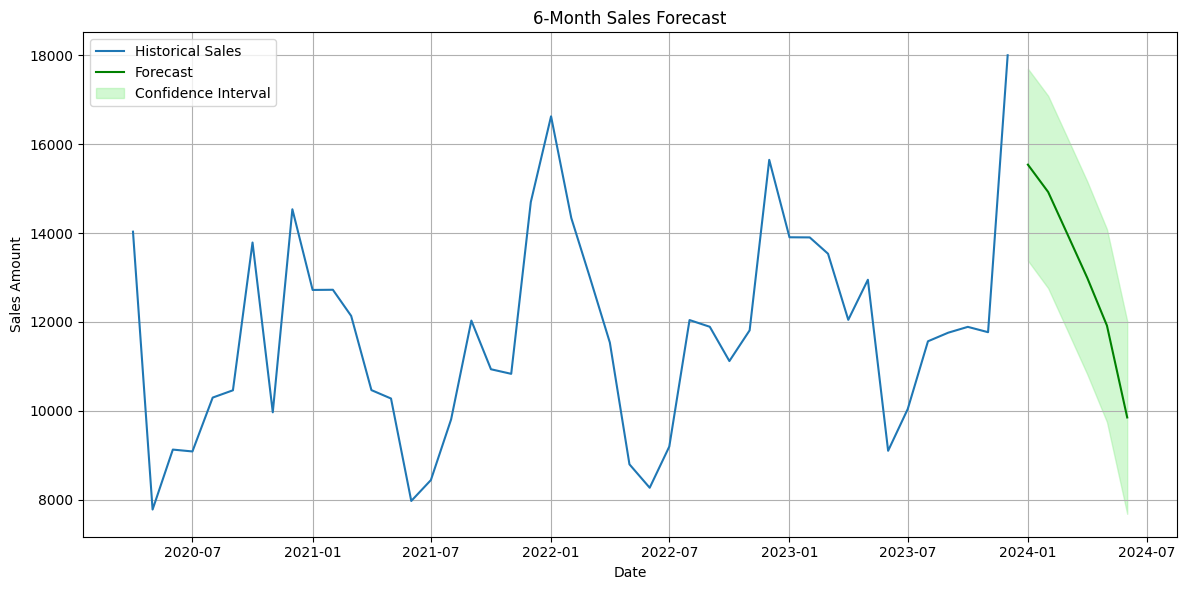

In [ ]:
import matplotlib.pyplot as plt

# Forecast 6 months ahead
forecast_steps = 6
forecast_result = final_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot historical + forecast
plt.figure(figsize=(12, 6))
plt.plot(full_data['SalesAmount'], label='Historical Sales')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='green')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.4, label='Confidence Interval')

plt.title('6-Month Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Sales Forecasting Report
Data Summary
Period: Monthly sales data from Jan 2020 to Dec 2023.

Total records: 48 months.

Frequency: Monthly (MS)

Target: SalesAmount

EDA Findings
Clear upward trend in sales.

Seasonality observed annually.

Stationarity confirmed post-differencing via Dickey-Fuller test.

Feature Engineering
Created:

Lag features

Month indicators (seasonality)

(Holiday/promo data not included)

Model Selection & Evaluation
Tried: SARIMA

Final model: (1,1,1)(1,1,1,12)

Metrics on validation:

MAE: ~1211.46

RMSE: ~1398.71

Final Forecast
Model retrained on full dataset.

6-month forecast generated with 95% confidence intervals.

Visualization provided above.



In [ ]:
# Save forecast to CSV
forecast_df = pd.DataFrame({
    'Date': forecast_mean.index,
    'Forecasted_Sales': forecast_mean.values,
    'Lower_CI': conf_int.iloc[:, 0],
    'Upper_CI': conf_int.iloc[:, 1]
})

forecast_df.to_csv('6_month_sales_forecast.csv', index=False)
print("✅ Forecast saved as '6_month_sales_forecast.csv'")


✅ Forecast saved as '6_month_sales_forecast.csv'
